In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
the_path = '/content/gdrive/My Drive/master_thesis/'
! ls gdrive/My\ Drive/master_thesis

aisin_gioro_models		     model
codes				     papers
data				     predictions
dev.0				     relation_descriptions.json
extended_relation_descriptions.json


In [0]:
import numpy as np
import re
import random
import json
import collections
import pickle
import os
import importlib

In [0]:
train_mnli_path = the_path + "data/multinli_0.9/multinli_0.9_train.jsonl"
dev_match_path = the_path + "data/multinli_0.9/multinli_0.9_dev_matched.jsonl"
dev_mismatch_path = the_path + "data/multinli_0.9/multinli_0.9_dev_mismatched.jsonl"

train_uwre_path = the_path + "data/uwre/train."
dev_uwre_path = the_path + "data/uwre/dev."
test_uwre_path = the_path + "data/uwre/test."

In [0]:
with open(train_uwre_path + "0") as f:
  for line in f:
    print(line)
    break

with open(train_mnli_path) as f:
  for line in f:
    print(line)
    break

{"gold_label": "entailment", "relation": "place of birth", "sentence": "SUBJECT_ENTITY Romero (1916 in OBJECT_ENTITY, Cuba -- 1997) was a prominent Cuban guitarist and one of the founders of the modern Cuban Guitar School.", "pairID": "Isaac Nicola1"}

{"annotator_labels": ["neutral"], "genre": "government", "gold_label": "neutral", "pairID": "335730n", "promptID": "335730n", "sentence1": "Conceptually cream skimming has two basic dimensions - product and geography.", "sentence1_binary_parse": "( ( Conceptually ( cream skimming ) ) ( ( has ( ( ( two ( basic dimensions ) ) - ) ( ( product and ) geography ) ) ) . ) )", "sentence1_parse": "(ROOT (S (NP (JJ Conceptually) (NN cream) (NN skimming)) (VP (VBZ has) (NP (NP (CD two) (JJ basic) (NNS dimensions)) (: -) (NP (NN product) (CC and) (NN geography)))) (. .)))", "sentence2": "Product and geography are what make cream skimming work. ", "sentence2_binary_parse": "( ( ( Product and ) geography ) ( ( are ( what ( make ( cream ( skimming work

In [0]:
def load_uwre_data(path):
    """
    Load UWRE data.
    "uwre" is set to "genre". 
    """
    relation_dict = {}
    positive_relation = {}
    negative_relation = {}
    
    entail_dict = {}
    entail_list = []
    
    with open(path) as f:
        for line in f:
            loaded_example = json.loads(line)
            
            entail = loaded_example["gold_label"]
            relation = loaded_example["relation"]
            
            if relation not in relation_dict:
                relation_dict[relation] = 1
            else:
                relation_dict[relation] += 1
                
            if entail not in entail_dict:
                entail_dict[entail] = 1
            else:
                entail_dict[entail] += 1
                
            if entail == 'entailment':
              entail_list.append(0)
              if relation in positive_relation:
                positive_relation[relation] += 1
              else:
                positive_relation[relation] = 1
            
            elif entail == 'neutral':
              entail_list.append(1)
              if relation in negative_relation:
                negative_relation[relation] += 1
              else:
                negative_relation[relation] = 1
            else:
              print("illegal entail label:", entail)
    return relation_dict, entail_dict, entail_list, positive_relation, negative_relation


In [0]:
# check specific relation

specific_list = []
specific_relation = 'publication date'

for i in range(10):
  current_train = train_uwre_path + str(i)
  current_dev = dev_uwre_path + str(i)
  current_test = test_uwre_path + str(i)
  
  for path in [current_train, current_dev, current_test]:
    with open(path) as f:
        for line in f:
            loaded_example = json.loads(line)
            entail = loaded_example["gold_label"]
            relation = loaded_example["relation"]
            sentence = loaded_example["sentence"]
            if relation == specific_relation:
              specific_list.append((entail, sentence))
  

In [0]:
specific_list[:10]

[('entailment',
  'SUBJECT_ENTITY is a OBJECT_ENTITY Italian comedy film written and directed by Pasquale Festa Campanile.'),
 ('entailment',
  'SUBJECT_ENTITY (Such a Lovely Town...) is a OBJECT_ENTITY French film directed by Étienne Périer.'),
 ('entailment',
  'SUBJECT_ENTITY (Kannada: ಸತಿಶಕ್ತಿ) is a OBJECT_ENTITY Indian Kannada film, directed by Kanagal Prabhakar Shastry and produced by Kanagal Prabhakar Shastry.'),
 ('entailment',
  'SUBJECT_ENTITY (Chinese: 白雪公主之矮人力量) is a OBJECT_ENTITY Chinese animated comedy fantasy adventure film directed by Adam Qiu.'),
 ('entailment',
  'SUBJECT_ENTITY is a OBJECT_ENTITY Hindi-language film directed by Gaurav Panjwani, art direction by Priyanka Agarwal, featuring Mohit Chauhan, Vishal Nayak, Charu Rahtogi and Sayani Gupta in the lead roles.'),
 ('neutral',
  'The film was directed by Elliot Silverstein from a screenplay by OBJECT_ENTITY and Frank Pierson from the novel The Ballad of SUBJECT_ENTITY by Roy Chanslor.\n'),
 ('neutral',
  'Rattan

In [0]:
# check specific relation

specific_list1 = []
specific_relation1 = 'native language'

for i in range(10):
  current_train = train_uwre_path + str(i)
  current_dev = dev_uwre_path + str(i)
  current_test = test_uwre_path + str(i)
  
  for path in [current_train, current_dev, current_test]:
    with open(path) as f:
        for line in f:
            loaded_example = json.loads(line)
            entail = loaded_example["gold_label"]
            relation = loaded_example["relation"]
            sentence = loaded_example["sentence"]
            if relation == specific_relation1:
              specific_list1.append((entail, sentence))
  

In [0]:
train_relation_dicts = []
train_entail_dicts = []
train_entail_list = []

dev_relation_dicts = []
dev_entail_dicts = []
dev_entail_list = []

test_relation_dicts = []
test_entail_dicts = []
test_entail_list = []

train_positive = []
train_negative = []
dev_positive = []
dev_negative = []
test_positive = []
test_negative = []

for i in range(10):
  current_train = train_uwre_path + str(i)
  current_dev = dev_uwre_path + str(i)
  current_test = test_uwre_path + str(i)
  
  train_relation, train_entail, train_ent, train_p, train_n = load_uwre_data(current_train)
  dev_relation, dev_entail, dev_ent, dev_p, dev_n = load_uwre_data(current_dev)
  test_relation, test_entail, test_ent, test_p, test_n = load_uwre_data(current_test)
  
  train_positive.append(train_p)
  train_negative.append(train_n)
  dev_positive.append(dev_p)
  dev_negative.append(dev_n)
  test_positive.append(test_p)
  test_negative.append(test_n)
  
  train_relation_dicts.append(train_relation)
  train_entail_dicts.append(train_entail)
  train_entail_list.extend(train_ent)
  
  dev_relation_dicts.append(dev_relation)
  dev_entail_dicts.append(dev_entail)
  dev_entail_list.extend(dev_ent)
  
  test_relation_dicts.append(test_relation)
  test_entail_dicts.append(test_entail)
  test_entail_list.extend(test_ent)

In [0]:
def ent_ave(ent_list):
  ent = []
  neu = []
  for d in ent_list:
    ent.append(d['entailment'])
    neu.append(d['neutral'])
  ave_ent = sum(ent)/len(ent)
  neu_ent = sum(neu)/len(neu)
  
  return ave_ent, neu_ent
    
train_ent, train_neu = ent_ave(train_entail_dicts)
dev_ent, dev_neu = ent_ave(dev_entail_dicts)
test_ent, test_neu = ent_ave(test_entail_dicts)

In [0]:
train_ent, train_neu

(409495.7, 420000.0)

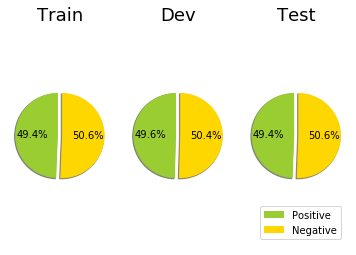

In [0]:
import matplotlib.pyplot as plt
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Positive', 'Negative']
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']

fig, axs = plt.subplots(1, 3)
axs[0].set_title('Train', fontsize=18)
axs[1].set_title('Dev', fontsize=18)
axs[2].set_title('Test', fontsize=18)

axs[0].pie([train_ent, train_neu], colors=colors, explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


axs[1].pie([dev_ent, dev_neu], colors=colors, explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


axs[2].pie([test_ent, test_neu], colors=colors, explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=90)
axs[2].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


plt.legend(labels, loc='lower right')
plt.show()

In [0]:
def cal_off(positive, negative):
  offset = {}

  for i in range(len(positive)):
    tp = positive[i]
    tn = negative[i]
    for counter, relation in enumerate(tp):
      if relation in offset:
        offset[relation].append((tn[relation] - tp[relation])/tn[relation])
      else:
        offset[relation] = [(tn[relation] - tp[relation])/tn[relation]]
     
  offset_ave = {}
  
  for r in offset.keys():
    offset_ave[r] = sum(offset[r])/len(offset[r])
    
  return offset_ave
        
train_off = cal_off(train_positive, train_negative)
dev_off = cal_off(dev_positive, dev_negative)
test_off = cal_off(test_positive, test_negative)

In [0]:
list(train_off.keys())[83]

'cast member'

In [0]:
train_off

In [0]:
train_off_list = [train_off[r] for r in train_off]
dev_off_list = [dev_off[r] for r in dev_off]
test_off_list = [test_off[r] for r in test_off]

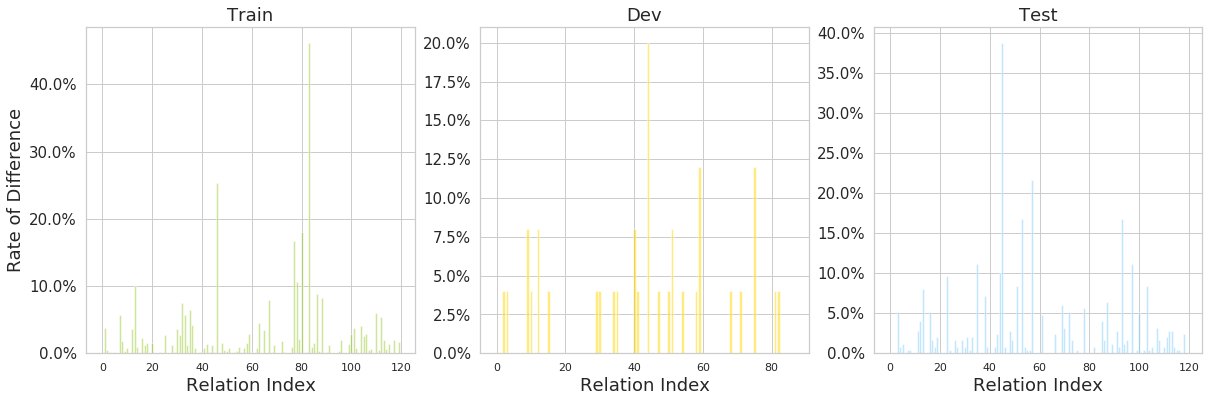

In [0]:
from matplotlib import ticker

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']

fig, axs = plt.subplots(1, 3, figsize=(20,6))

axs[0].set_title('Train', fontsize=18)
axs[0].set_xlabel('Relation Index', fontsize=18)
axs[0].set_ylabel('Rate of Difference', fontsize=18)

axs[0].yaxis.set_major_formatter(ticker.PercentFormatter())
axs[1].yaxis.set_major_formatter(ticker.PercentFormatter())
axs[2].yaxis.set_major_formatter(ticker.PercentFormatter())

axs[1].set_title('Dev', fontsize=18)
axs[1].set_xlabel('Relation Index', fontsize=18)

axs[2].set_title('Test', fontsize=18)
axs[2].set_xlabel('Relation Index', fontsize=18)

axs[0].bar(range(len(train_off)), [100 * i for i in train_off_list], align='center', alpha=0.5, color=['yellowgreen'])

axs[1].bar(range(len(dev_off)), [100 * i for i in dev_off_list], align='center', alpha=0.5, color=['gold'])

axs[2].bar(range(len(test_off)), [100 * i for i in test_off_list], align='center', alpha=0.5,color=['lightskyblue'])


plt.show()

([<matplotlib.axis.XTick at 0x7fa681b2c828>,
 <a list of 3 Text xticklabel objects>)

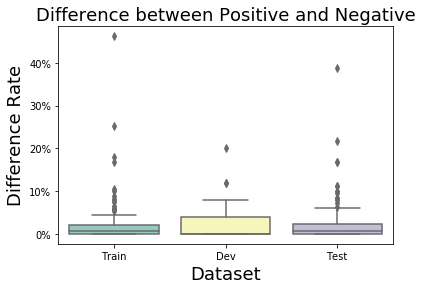

In [0]:
import seaborn as sns

hun_train = [100 * i for i in train_off_list]
hun_dev = [100 * i for i in dev_off_list]
hun_test = [100 * i for i in test_off_list]

fig, ax = plt.subplots()
sns.set(style="whitegrid") # , palette= "Blues"
sns.boxplot(data=[hun_train,hun_dev, hun_test], palette="Set3", ax=ax)

ax.yaxis.set_major_formatter(ticker.PercentFormatter())
ax.set_title('Difference between Positive and Negative', fontsize=18)
ax.set_xlabel('Dataset', fontsize=18)
ax.set_ylabel('Difference Rate', fontsize=18)
plt.xticks([0, 1, 2], ['Train', 'Dev', 'Test'])

In [0]:
def relation_ave(rel_lists):
  
  sum_dict = {}
  
  for relation_list in rel_lists:
    the_sum = sum([relation_list[rel] for rel in relation_list.keys()])
    for relation in relation_list:
      perc = relation_list[relation]/the_sum
      if relation in sum_dict:
        sum_dict[relation].append(perc)
      else:
        sum_dict[relation] = [perc]
  
  aves = {}
  
  for r in sum_dict.keys():
    aves[r] = sum(sum_dict[r])/len(sum_dict[r])
  
  return aves
    
train_rel = relation_ave(train_relation_dicts)
dev_rel = relation_ave(dev_relation_dicts)
test_rel = relation_ave(test_relation_dicts)

In [0]:
train_rel_list = [train_rel[r] for r in train_rel]
dev_rel_list = [dev_rel[r] for r in dev_rel]
test_rel_list = [test_rel[r] for r in test_rel]

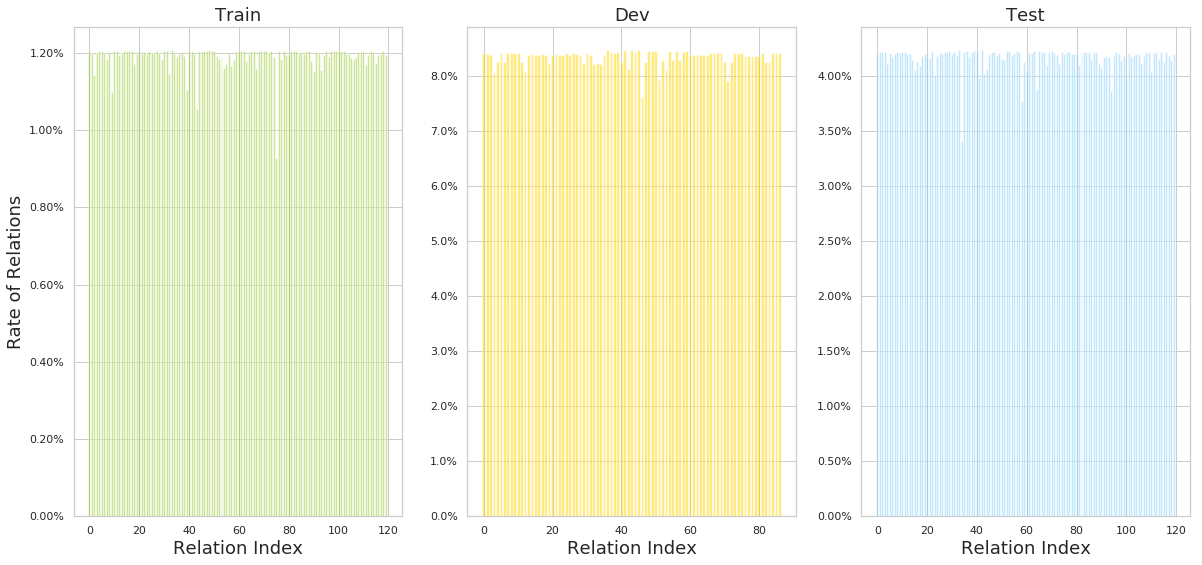

In [0]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']

fig, axs = plt.subplots(1, 3, figsize=(20,9))
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
import matplotlib

matplotlib.rc('ytick', labelsize=18)

axs[0].yaxis.set_major_formatter(ticker.PercentFormatter())
axs[1].yaxis.set_major_formatter(ticker.PercentFormatter())
axs[2].yaxis.set_major_formatter(ticker.PercentFormatter())

axs[0].set_title('Train', fontsize=18)
axs[0].set_xlabel('Relation Index', fontsize=18)
axs[0].set_ylabel('Rate of Relations', fontsize=18)

axs[1].set_title('Dev', fontsize=18)
axs[1].set_xlabel('Relation Index', fontsize=18)


axs[2].set_title('Test', fontsize=18)
axs[2].set_xlabel('Relation Index', fontsize=18)

axs[0].bar(range(len(train_rel)), [100 * i for i in train_rel_list], align='center', alpha=0.5, color=['yellowgreen'])

axs[1].bar(range(len(dev_rel)), [100 * i for i in dev_rel_list], align='center', alpha=0.5, color=['gold'])

axs[2].bar(range(len(test_rel)), [100 * i for i in test_rel_list], align='center', alpha=0.5,color=['lightskyblue'])


plt.show()

In [0]:
import json
with open(the_path + "extended_relation_descriptions.json", 'r') as file:
    relation_descriptions = json.load(file)

In [0]:
len(relation_descriptions)

120

In [0]:
# relation_descriptions_num = {r:len(relation_descriptions[r]) for r in relation_descriptions}
relation_descriptions_num = [len(relation_descriptions[r]) for r in relation_descriptions]

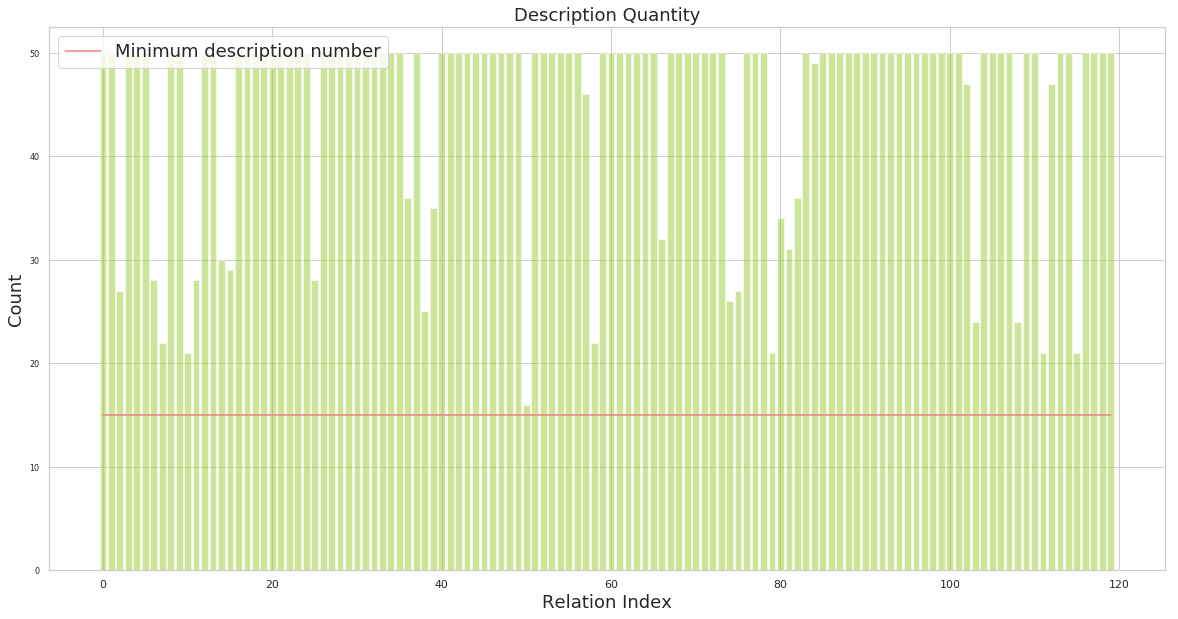

In [0]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']

fig, ax = plt.subplots(figsize=(20,10))
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
import matplotlib

matplotlib.rc('ytick', labelsize=15)

ax.set_title('Description Quantity', fontsize=18)
ax.set_xlabel('Relation Index', fontsize=18)
# ax.yaxis.set_label_coords(-0.1,1)
ax.set_ylabel('Count', fontsize=18)


ax.bar(range(len(relation_descriptions_num)), relation_descriptions_num, align='center', alpha=0.5, color=['yellowgreen'])

line, = ax.plot([15] * 120, label='Minimum description number', color='lightcoral')
ax.legend(fontsize=18)

# plt.axvline(x=[15], label='Minimum description number', color='lightcoral')
    

plt.show()